**Deep Generative View on Continual Learning: assignment** \\
*PhD in Data Science - Sapienza University of Rome* \\
Candidates: Stefania Fiandrino, Vittoria Vineis

###Imports and pre-processing

In [ ]:
# pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [1]:
pip install thop

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, TensorDataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from thop import profile

import numpy as np
from copy import deepcopy

# import wandb
import os
from random import shuffle

In [4]:
def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.5), (0.5)
    elif dataset == 'FASHION-MNIST':
        raise NotImplementedError

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean=mean, std=std)
        ])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform,
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    train_dataset
    val_dataset

    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

###Metrics

In [15]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def count_ops(model, input_size):
    dummy_input = torch.randn(1, *input_size).to(device)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)
    return macs

def compute_ops_per_epoch(data_loader, model):
    ops_per_batch = count_ops(model, next(iter(data_loader))[0].shape[1:])
    num_batches = len(data_loader)
    return ops_per_batch * num_batches

def compute_computational_efficiency(ops, ops_updown, num_tasks, epsilon=1.0):
    ratio_sum = sum(ops_updown[i] * epsilon / ops[i] for i in range(num_tasks))
    ce = min(1, ratio_sum / num_tasks)
    return ce


In [6]:
class Statistics:
    def __init__(self, task_names):
        self.task_names = task_names
        self.train_loss = {key: [] for key in task_names}
        self.train_accuracy = {key: [] for key in task_names}
        self.val_loss = {key: [] for key in task_names}
        self.val_accuracy = {key: [] for key in task_names}
        self.generated_samples = {key: 0 for key in task_names}
        self.original_samples = {key: 0 for key in task_names}

    def update_train_stats(self, task, epoch_loss, correct, total):
        self.train_loss[task].append(epoch_loss)
        self.train_accuracy[task].append(correct / total)

    def update_val_stats(self, task, epoch_loss, correct, total):
        self.val_loss[task].append(epoch_loss)
        self.val_accuracy[task].append(correct / total)

    def update_sample_counts(self, task, generated_samples, original_samples):
        self.generated_samples[task] = generated_samples
        self.original_samples[task] = original_samples

    def print_stats(self):
        for task in self.task_names:
            print(f"Task {task} ---- ")
            print(f"Train Loss: {self.train_loss[task]}")
            print(f"Train Accuracy: {self.train_accuracy[task]}")
            print(f"Validation Loss: {self.val_loss[task]}")
            print(f"Validation Accuracy: {self.val_accuracy[task]}")
            print(f"Generated Samples: {self.generated_samples[task]}")
            print(f"Original Samples: {self.original_samples[task]}")


###Generative model: VAE

In [7]:
#Reference for VAE implementation:
#https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb

class VAE(nn.Module):
    def __init__(self, x_dim=784, h_dim1 = 128, h_dim2 = 8):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc21 = nn.Linear(h_dim1, h_dim2)
        self.fc22 = nn.Linear(h_dim1, h_dim2)
        #decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def sampling(self, mu, std):
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu))

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, self.x_dim))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std


class VAE_buffer:
    def __init__(self, sample_size, args):
        self.sample_size = sample_size
        self.n_epochs = args['epochs_VAE']
        self._loss_history = []
        # loss
        self.criterion = nn.BCELoss()
        # optimizer
        self.lr_VAE = args['lr_VAE']
        self.data_dim = args['in_size']**2 * args['n_channels']
        self.h_dim1 = 128
        self.h_dim2 = 8
        self.device = args['device']

    def loss_function(self, y, x, mu, std):
        # return reconstruction error + KL divergence losses
        BCE = F.binary_cross_entropy(y, x.view(-1, self.data_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
        return BCE + KLD

    def train_vae(self, real_data_loader):
        self.VAE = VAE(x_dim = self.data_dim, h_dim1 = self.h_dim1, h_dim2 = self.h_dim2).to(device)
        self.optimizer = optim.Adam(self.VAE.parameters(), lr = self.lr_VAE)

        for epoch in range(1, self.n_epochs):
            train_loss = 0
            for batch_idx, (data, _) in enumerate(real_data_loader):
                self.VAE.train()
                bsize = data.shape[0]
                recon_batch, mu, std = self.VAE(data)
                loss = self.loss_function(recon_batch, data, mu, std)
                loss.backward()
                train_loss += loss
                self.optimizer.step()
                self.optimizer.zero_grad()
            print(f'Epoch [{epoch}/{ self.n_epochs}] | Loss: {train_loss / len(real_data_loader.dataset):.4f}')

    def get_data(self):
        self.VAE.eval()
        z = np.random.normal(0,1, (self.sample_size, 8))
        z = z.astype(np.float32)
        z = torch.from_numpy(z)
        recon = self.VAE.decoder(z)
        b = recon.view(-1, 1, 28, 28)
        return b.detach().cpu()

###CL model - class incremental

In [8]:
device = 'cpu'

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        model = MLP(self.args)

        self.model = model.to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
        self.statistics = Statistics(self.args['task_names'])

        self.buffer = VAE_buffer(sample_size=args['sample_size'], args=args)

        # wandb.init(project="CL_assignment", config=self.args, entity='vvineis')
        # wandb.watch(self.model)

    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def print_statistics(self):
        self.statistics.print_stats()

    def train(self):
        for task, data in self.train_datasets.items():
            print(f"Task {task} ---- ")
            loader = DataLoader(data, batch_size=self.args['bs'], )
            samples, targets = zip(*loader)
            orig_samples = []
            orig_targets = []

            for sample, target in zip(samples, targets):
                orig_samples.append(sample)
                orig_targets.append(target.long())

            orig_samples = torch.cat(orig_samples)
            orig_targets = torch.cat(orig_targets)

            original_sample_count = len(orig_samples)
            generated_sample_count = 0

            if int(task)==0:
                self.buffer.train_vae(loader)
            else:
                with torch.no_grad():
                    buffer_samples = self.buffer.get_data()
                    buffer_targets = self.model(buffer_samples.to(device)).argmax(dim=1).cpu().long()

                all_samples = torch.cat((buffer_samples, orig_samples))
                all_targets = torch.cat((buffer_targets, orig_targets))

                merged_data = TensorDataset(all_samples.clone(), all_targets.clone())
                loader = DataLoader(merged_data, batch_size=self.args['bs'], shuffle=True)

                self.buffer.train_vae(loader)
                generated_sample_count = len(buffer_samples)

            for epoch in range(self.args['epochs']):
                #self.model.train()
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(loader):
                    X, y = X.to(device), y.to(device).long()  # Ensure targets are of type Long
                    output = self.model(X)
                    loss = self.criterion(output, y)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, 1)[1].squeeze(1) == y).item()
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                    avg_epoch_loss = epoch_loss / (e + 1)
                    accuracy = correct / total

                self.statistics.update_train_stats(task, avg_epoch_loss, correct, total)
                print(f"Epoch {epoch}: Loss {avg_epoch_loss:.3f} Acc: {accuracy:.3f}")
                # wandb.log({
                #     f"train_loss_task_{task}": avg_epoch_loss,
                #     f"train_accuracy_task_{task}": accuracy,
                # })

            self.statistics.update_sample_counts(task, generated_sample_count, original_sample_count)
            self.validate(end_of_epoch=True)

    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            correct, total = 0, 0
            total_loss = 0
            for e, (X, y) in enumerate(loader):
                X, y = X.to(device), y.to(device)
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            avg_loss = total_loss / total
            accuracy = correct / total
            self.acc[task].append(accuracy)
            if end_of_epoch:
                self.acc_end[task].append(accuracy)
                self.statistics.update_val_stats(task, avg_loss, correct, total)
                # wandb.log({
                #     f"val_loss_task_{task}": avg_loss,
                #     f"val_accuracy_task_{task}": accuracy
                # })
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x_mlp = input.flatten(start_dim=1)
        x_mlp = torch.nn.functional.relu(self.fc1(x_mlp))
        x_mlp = torch.nn.functional.relu(self.fc2(x_mlp))
        x_mlp = torch.nn.functional.relu(self.fc3(x_mlp))
        x_mlp = self.fc4(x_mlp)
        return x_mlp


###Sweeps & results

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'0': [6, 0], '1': [8, 4], '2': [2, 1], '3': [9, 3], '4': [7, 5]}
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12604062.83it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 382538.20it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3674496.65it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1289375.89it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Create sweep with ID: 7iqu8z7v
Sweep URL: https://wandb.ai/vvineis/CL_assignment_final/sweeps/7iqu8z7v


wandb: Agent Starting Run: 1w9wqtl4 with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 10
wandb: 	lr: 0.001
wandb: 	sample_size: 8000
wandb: Currently logged in as: vvineis. Use `wandb login --relogin` to force relogin


Task 0 ---- 
Epoch [1/10] | Loss: 283.6546
Epoch [2/10] | Loss: 186.6360
Epoch [3/10] | Loss: 170.7964
Epoch [4/10] | Loss: 159.0462
Epoch [5/10] | Loss: 151.0706
Epoch [6/10] | Loss: 144.2672
Epoch [7/10] | Loss: 140.1476
Epoch [8/10] | Loss: 136.9629
Epoch [9/10] | Loss: 134.5360
Epoch 0: Loss 0.500 Acc: 0.906
Epoch 1: Loss 0.036 Acc: 0.988
Epoch 2: Loss 0.030 Acc: 0.990
Task 1 ---- 
Epoch [1/10] | Loss: 321.2762
Epoch [2/10] | Loss: 252.3632
Epoch [3/10] | Loss: 237.6208
Epoch [4/10] | Loss: 227.9331
Epoch [5/10] | Loss: 221.3490
Epoch [6/10] | Loss: 223.4229
Epoch [7/10] | Loss: 219.1022
Epoch [8/10] | Loss: 215.5614
Epoch [9/10] | Loss: 205.8503
Epoch 0: Loss 0.586 Acc: 0.840
Epoch 1: Loss 0.057 Acc: 0.981
Epoch 2: Loss 0.040 Acc: 0.987
Task 2 ---- 
Epoch [1/10] | Loss: 280.3011
Epoch [2/10] | Loss: 212.0917
Epoch [3/10] | Loss: 193.2910
Epoch [4/10] | Loss: 199.1370
Epoch [5/10] | Loss: 195.5998
Epoch [6/10] | Loss: 187.2879
Epoch [7/10] | Loss: 182.9304
Epoch [8/10] | Loss: 180.

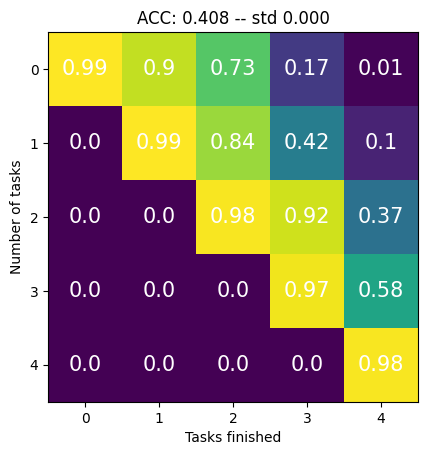

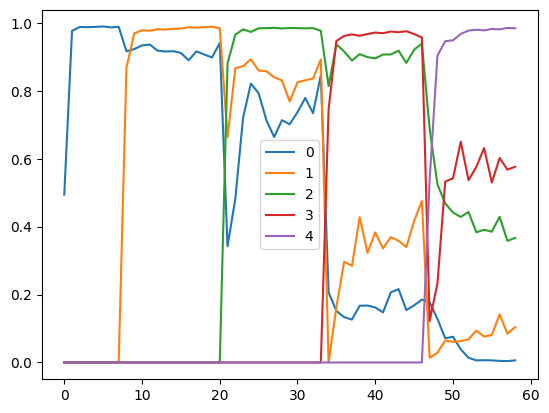

The average accuracy at the end of sequence is: 0.408
BWT: -0.719
FWT: -0.005


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁██
train_accuracy_task_1,▁██
train_accuracy_task_2,▁██
train_accuracy_task_3,▁██
train_accuracy_task_4,▁██
train_loss_task_0,█▁▁
train_loss_task_1,█▁▁
train_loss_task_2,█▁▁


wandb: Agent Starting Run: 4mfjf17e with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 10
wandb: 	lr: 0.001
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/10] | Loss: 292.2427
Epoch [2/10] | Loss: 193.6649
Epoch [3/10] | Loss: 172.7141
Epoch [4/10] | Loss: 161.9857
Epoch [5/10] | Loss: 152.9133
Epoch [6/10] | Loss: 146.6837
Epoch [7/10] | Loss: 141.9194
Epoch [8/10] | Loss: 138.5177
Epoch [9/10] | Loss: 134.8119
Epoch 0: Loss 0.543 Acc: 0.816
Epoch 1: Loss 0.033 Acc: 0.989
Epoch 2: Loss 0.027 Acc: 0.991
Task 1 ---- 
Epoch [1/10] | Loss: 307.5498
Epoch [2/10] | Loss: 258.7814
Epoch [3/10] | Loss: 241.1778
Epoch [4/10] | Loss: 237.4317
Epoch [5/10] | Loss: 233.2747
Epoch [6/10] | Loss: 235.5914
Epoch [7/10] | Loss: 229.7244
Epoch [8/10] | Loss: 220.8764
Epoch [9/10] | Loss: 219.5047
Epoch 0: Loss 0.550 Acc: 0.842
Epoch 1: Loss 0.065 Acc: 0.981
Epoch 2: Loss 0.048 Acc: 0.985
Task 2 ---- 
Epoch [1/10] | Loss: 273.7246
Epoch [2/10] | Loss: 220.1622
Epoch [3/10] | Loss: 208.4339
Epoch [4/10] | Loss: 201.9967
Epoch [5/10] | Loss: 201.9882
Epoch [6/10] | Loss: 193.2829
Epoch [7/10] | Loss: 189.9568
Epoch [8/10] | Loss: 187.

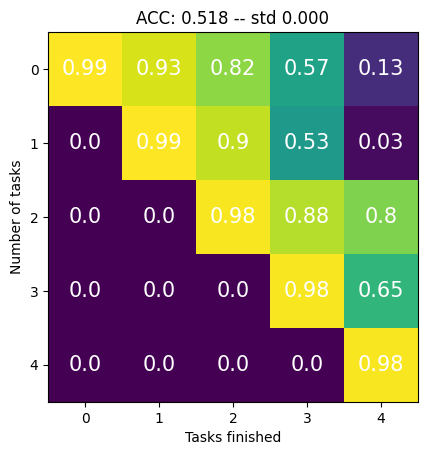

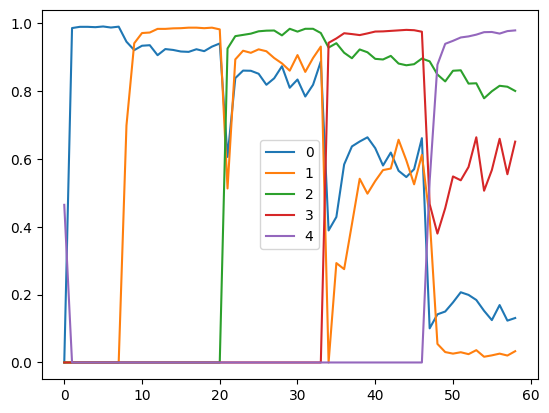

The average accuracy at the end of sequence is: 0.519
BWT: -0.580
FWT: -0.116


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁██
train_accuracy_task_1,▁██
train_accuracy_task_2,▁██
train_accuracy_task_3,▁▇█
train_accuracy_task_4,▁██
train_loss_task_0,█▁▁
train_loss_task_1,█▁▁
train_loss_task_2,█▁▁


wandb: Agent Starting Run: o39vvs5d with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 10
wandb: 	lr: 1e-05
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/10] | Loss: 288.0271
Epoch [2/10] | Loss: 190.8500
Epoch [3/10] | Loss: 170.1240
Epoch [4/10] | Loss: 163.1521
Epoch [5/10] | Loss: 155.4227
Epoch [6/10] | Loss: 150.0289
Epoch [7/10] | Loss: 144.6373
Epoch [8/10] | Loss: 140.2371
Epoch [9/10] | Loss: 136.6656
Epoch 0: Loss 2.235 Acc: 0.500
Epoch 1: Loss 2.200 Acc: 0.500
Epoch 2: Loss 2.150 Acc: 0.500
Task 1 ---- 
Epoch [1/10] | Loss: 310.8713
Epoch [2/10] | Loss: 248.6896
Epoch [3/10] | Loss: 235.2289
Epoch [4/10] | Loss: 224.7885
Epoch [5/10] | Loss: 226.2980
Epoch [6/10] | Loss: 218.2475
Epoch [7/10] | Loss: 229.3145
Epoch [8/10] | Loss: 216.9487
Epoch [9/10] | Loss: 215.4100
Epoch 0: Loss 2.099 Acc: 0.406
Epoch 1: Loss 1.915 Acc: 0.406
Epoch 2: Loss 1.722 Acc: 0.406
Task 2 ---- 
Epoch [1/10] | Loss: 275.8024
Epoch [2/10] | Loss: 218.8260
Epoch [3/10] | Loss: 211.4230
Epoch [4/10] | Loss: 202.9302
Epoch [5/10] | Loss: 204.0546
Epoch [6/10] | Loss: 194.9749
Epoch [7/10] | Loss: 187.5436
Epoch [8/10] | Loss: 184.

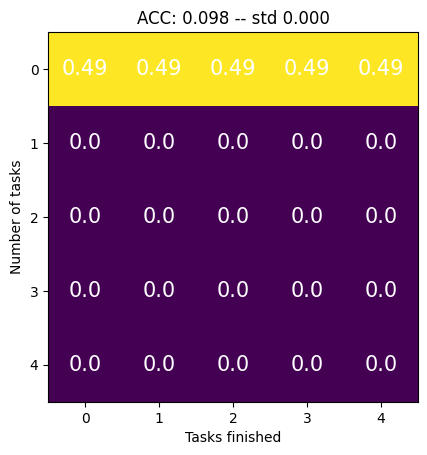

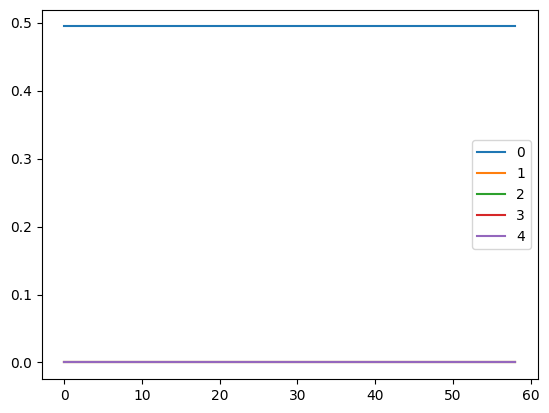

The average accuracy at the end of sequence is: 0.099
BWT: 0.000
FWT: 0.000


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁▁
train_accuracy_task_1,▁▁▁
train_accuracy_task_2,▁▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▅▁
train_loss_task_1,█▅▁
train_loss_task_2,█▄▁


wandb: Agent Starting Run: 3oitanb1 with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 10
wandb: 	lr: 1e-05
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/10] | Loss: 289.0373
Epoch [2/10] | Loss: 185.3253
Epoch [3/10] | Loss: 167.6679
Epoch [4/10] | Loss: 154.2644
Epoch [5/10] | Loss: 144.5797
Epoch [6/10] | Loss: 138.7831
Epoch [7/10] | Loss: 134.9846
Epoch [8/10] | Loss: 132.2542
Epoch [9/10] | Loss: 130.3566
Epoch 0: Loss 2.234 Acc: 0.019
Epoch 1: Loss 2.199 Acc: 0.324
Epoch 2: Loss 2.148 Acc: 0.493
Task 1 ---- 
Epoch [1/10] | Loss: 306.5337
Epoch [2/10] | Loss: 244.5846
Epoch [3/10] | Loss: 249.2174
Epoch [4/10] | Loss: 251.0891
Epoch [5/10] | Loss: 237.1263
Epoch [6/10] | Loss: 238.1873
Epoch [7/10] | Loss: 227.3714
Epoch [8/10] | Loss: 225.2242
Epoch [9/10] | Loss: 219.7820
Epoch 0: Loss 2.087 Acc: 0.477
Epoch 1: Loss 1.821 Acc: 0.476
Epoch 2: Loss 1.631 Acc: 0.476
Task 2 ---- 
Epoch [1/10] | Loss: 272.9419
Epoch [2/10] | Loss: 213.9367
Epoch [3/10] | Loss: 209.7172
Epoch [4/10] | Loss: 195.7556
Epoch [5/10] | Loss: 191.0127
Epoch [6/10] | Loss: 187.9524
Epoch [7/10] | Loss: 186.6975
Epoch [8/10] | Loss: 187.

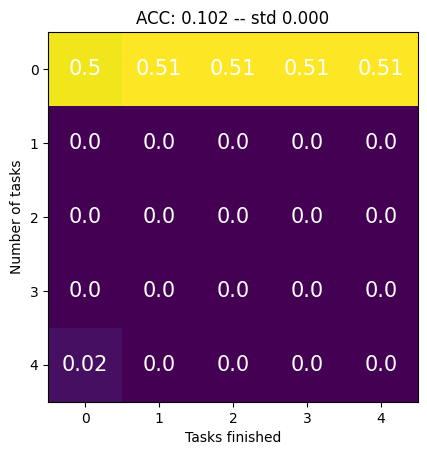

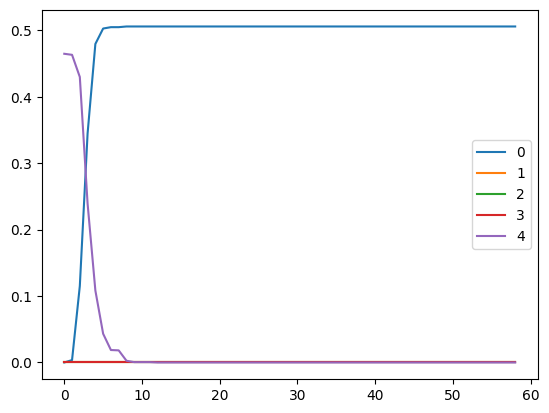

The average accuracy at the end of sequence is: 0.101
BWT: 0.000
FWT: -0.116


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▆█
train_accuracy_task_1,█▁▁
train_accuracy_task_2,▁▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▅▁
train_loss_task_1,█▄▁
train_loss_task_2,█▄▁


wandb: Agent Starting Run: xrxciz5u with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 30
wandb: 	lr: 0.001
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/30] | Loss: 288.6538
Epoch [2/30] | Loss: 182.5273
Epoch [3/30] | Loss: 164.9374
Epoch [4/30] | Loss: 152.1977
Epoch [5/30] | Loss: 145.0524
Epoch [6/30] | Loss: 140.6781
Epoch [7/30] | Loss: 136.6772
Epoch [8/30] | Loss: 133.3178
Epoch [9/30] | Loss: 131.0266
Epoch [10/30] | Loss: 129.0571
Epoch [11/30] | Loss: 127.4607
Epoch [12/30] | Loss: 126.3159
Epoch [13/30] | Loss: 125.0261
Epoch [14/30] | Loss: 123.8814
Epoch [15/30] | Loss: 122.8270
Epoch [16/30] | Loss: 121.7913
Epoch [17/30] | Loss: 120.9309
Epoch [18/30] | Loss: 119.9422
Epoch [19/30] | Loss: 119.1244
Epoch [20/30] | Loss: 118.4053
Epoch [21/30] | Loss: 117.6673
Epoch [22/30] | Loss: 117.0251
Epoch [23/30] | Loss: 116.2466
Epoch [24/30] | Loss: 115.6198
Epoch [25/30] | Loss: 115.0048
Epoch [26/30] | Loss: 114.4143
Epoch [27/30] | Loss: 113.9920
Epoch [28/30] | Loss: 113.3397
Epoch [29/30] | Loss: 112.9241
Epoch 0: Loss 0.537 Acc: 0.890
Epoch 1: Loss 0.034 Acc: 0.989
Epoch 2: Loss 0.029 Acc: 0.991
Task

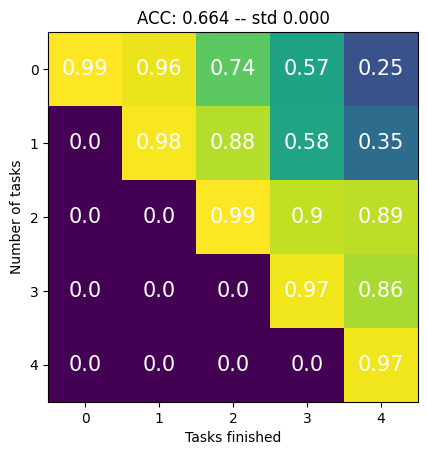

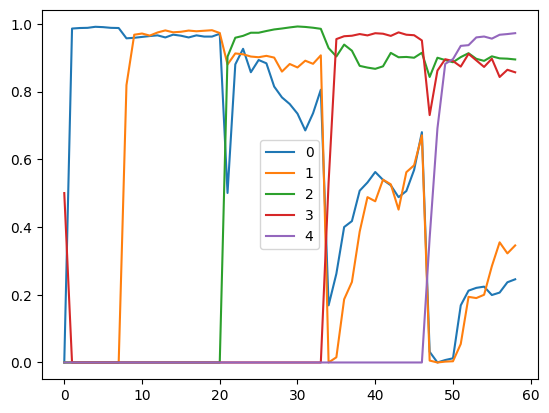

The average accuracy at the end of sequence is: 0.663
BWT: -0.395
FWT: -0.125


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁██
train_accuracy_task_1,▁██
train_accuracy_task_2,▁▇█
train_accuracy_task_3,▁▇█
train_accuracy_task_4,▁▇█
train_loss_task_0,█▁▁
train_loss_task_1,█▁▁
train_loss_task_2,█▁▁


wandb: Agent Starting Run: 6qkvw8mo with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 30
wandb: 	lr: 0.001
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/30] | Loss: 288.1212
Epoch [2/30] | Loss: 193.0513
Epoch [3/30] | Loss: 172.1650
Epoch [4/30] | Loss: 165.4555
Epoch [5/30] | Loss: 157.1611
Epoch [6/30] | Loss: 151.2908
Epoch [7/30] | Loss: 146.8611
Epoch [8/30] | Loss: 143.2671
Epoch [9/30] | Loss: 140.0950
Epoch [10/30] | Loss: 137.1009
Epoch [11/30] | Loss: 134.4052
Epoch [12/30] | Loss: 132.1048
Epoch [13/30] | Loss: 130.2730
Epoch [14/30] | Loss: 128.4829
Epoch [15/30] | Loss: 127.0946
Epoch [16/30] | Loss: 125.8143
Epoch [17/30] | Loss: 124.8188
Epoch [18/30] | Loss: 123.7423
Epoch [19/30] | Loss: 122.7510
Epoch [20/30] | Loss: 121.9103
Epoch [21/30] | Loss: 121.7994
Epoch [22/30] | Loss: 122.6463
Epoch [23/30] | Loss: 120.7515
Epoch [24/30] | Loss: 119.7258
Epoch [25/30] | Loss: 118.7568
Epoch [26/30] | Loss: 117.9728
Epoch [27/30] | Loss: 119.5419
Epoch [28/30] | Loss: 117.6787
Epoch [29/30] | Loss: 119.6637
Epoch 0: Loss 0.512 Acc: 0.895
Epoch 1: Loss 0.035 Acc: 0.989
Epoch 2: Loss 0.029 Acc: 0.990
Task

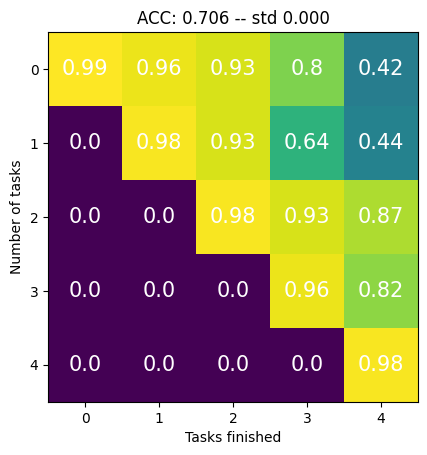

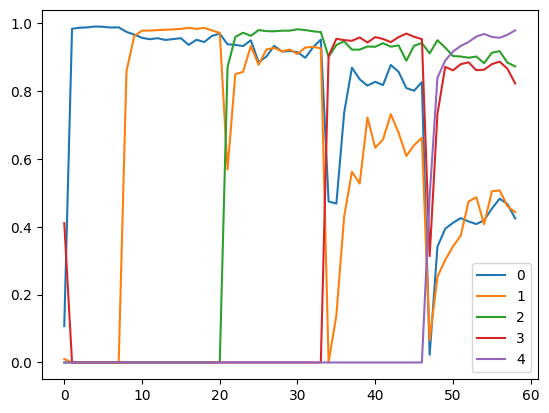

The average accuracy at the end of sequence is: 0.709
BWT: -0.335
FWT: -0.099


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁██
train_accuracy_task_1,▁██
train_accuracy_task_2,▁██
train_accuracy_task_3,▁▇█
train_accuracy_task_4,▁▇█
train_loss_task_0,█▁▁
train_loss_task_1,█▁▁
train_loss_task_2,█▁▁


wandb: Agent Starting Run: dc1mzcw2 with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 30
wandb: 	lr: 1e-05
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/30] | Loss: 289.1938
Epoch [2/30] | Loss: 183.2043
Epoch [3/30] | Loss: 165.6755
Epoch [4/30] | Loss: 153.9868
Epoch [5/30] | Loss: 146.4592
Epoch [6/30] | Loss: 141.3408
Epoch [7/30] | Loss: 137.3747
Epoch [8/30] | Loss: 134.1536
Epoch [9/30] | Loss: 131.6370
Epoch [10/30] | Loss: 129.4975
Epoch [11/30] | Loss: 127.7151
Epoch [12/30] | Loss: 126.2390
Epoch [13/30] | Loss: 127.1132
Epoch [14/30] | Loss: 124.5030
Epoch [15/30] | Loss: 122.8792
Epoch [16/30] | Loss: 121.8309
Epoch [17/30] | Loss: 121.1277
Epoch [18/30] | Loss: 120.1147
Epoch [19/30] | Loss: 119.4012
Epoch [20/30] | Loss: 118.6800
Epoch [21/30] | Loss: 118.0920
Epoch [22/30] | Loss: 117.4380
Epoch [23/30] | Loss: 116.8878
Epoch [24/30] | Loss: 116.3160
Epoch [25/30] | Loss: 115.7532
Epoch [26/30] | Loss: 115.3004
Epoch [27/30] | Loss: 114.7940
Epoch [28/30] | Loss: 114.3403
Epoch [29/30] | Loss: 113.8649
Epoch 0: Loss 2.396 Acc: 0.000
Epoch 1: Loss 2.365 Acc: 0.000
Epoch 2: Loss 2.323 Acc: 0.000
Task

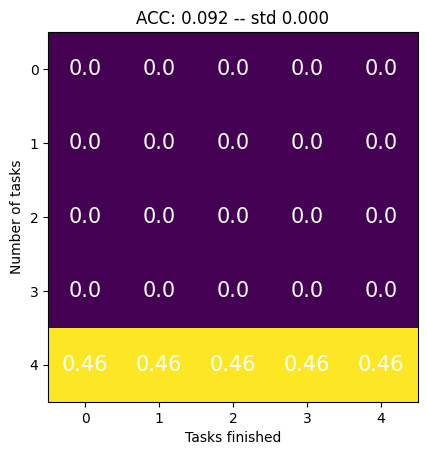

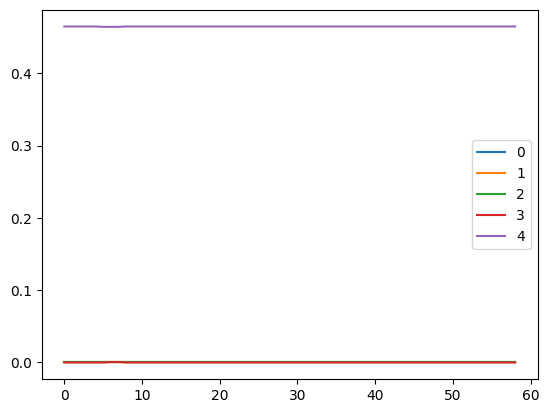

The average accuracy at the end of sequence is: 0.093
BWT: 0.000
FWT: 0.000


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁▁
train_accuracy_task_1,█▁▁
train_accuracy_task_2,▁▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▅▁
train_loss_task_1,█▅▁
train_loss_task_2,█▅▁


wandb: Agent Starting Run: vgn8x47j with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 30
wandb: 	lr: 1e-05
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/30] | Loss: 285.5399
Epoch [2/30] | Loss: 189.1616
Epoch [3/30] | Loss: 169.0547
Epoch [4/30] | Loss: 158.2241
Epoch [5/30] | Loss: 151.0630
Epoch [6/30] | Loss: 144.9460
Epoch [7/30] | Loss: 140.1411
Epoch [8/30] | Loss: 136.2968
Epoch [9/30] | Loss: 133.2930
Epoch [10/30] | Loss: 131.0489
Epoch [11/30] | Loss: 129.3748
Epoch [12/30] | Loss: 127.8980
Epoch [13/30] | Loss: 126.5972
Epoch [14/30] | Loss: 125.1880
Epoch [15/30] | Loss: 124.1141
Epoch [16/30] | Loss: 123.1538
Epoch [17/30] | Loss: 122.1931
Epoch [18/30] | Loss: 121.2808
Epoch [19/30] | Loss: 120.3966
Epoch [20/30] | Loss: 119.5706
Epoch [21/30] | Loss: 118.8290
Epoch [22/30] | Loss: 118.1995
Epoch [23/30] | Loss: 117.5266
Epoch [24/30] | Loss: 116.7644
Epoch [25/30] | Loss: 116.2411
Epoch [26/30] | Loss: 115.7161
Epoch [27/30] | Loss: 115.1597
Epoch [28/30] | Loss: 114.6231
Epoch [29/30] | Loss: 114.1539
Epoch 0: Loss 2.368 Acc: 0.000
Epoch 1: Loss 2.332 Acc: 0.000
Epoch 2: Loss 2.283 Acc: 0.001
Task

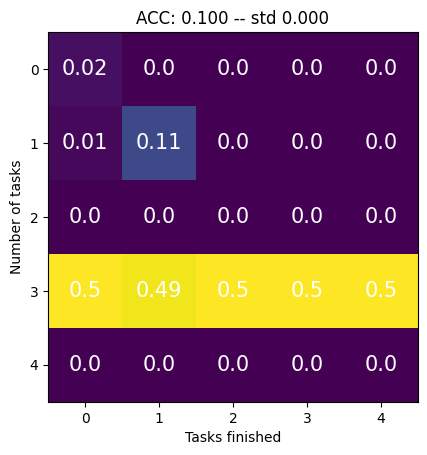

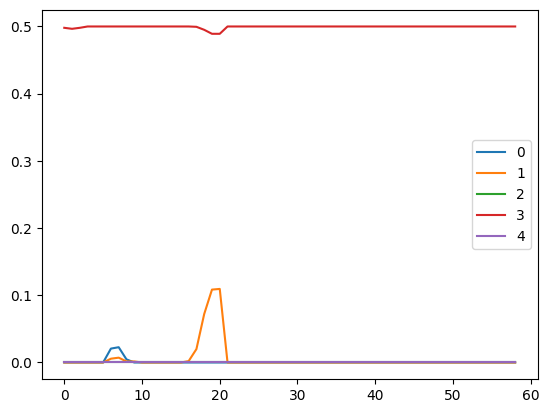

The average accuracy at the end of sequence is: 0.100
BWT: -0.032
FWT: 0.002


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁█
train_accuracy_task_1,█▁▅
train_accuracy_task_2,█▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▅▁
train_loss_task_1,█▅▁
train_loss_task_2,█▄▁


wandb: Agent Starting Run: cz2ojuki with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 10
wandb: 	lr: 0.001
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/10] | Loss: 282.7881
Epoch [2/10] | Loss: 182.6631
Epoch [3/10] | Loss: 166.6986
Epoch [4/10] | Loss: 157.1692
Epoch [5/10] | Loss: 149.1487
Epoch [6/10] | Loss: 142.6120
Epoch [7/10] | Loss: 138.1953
Epoch [8/10] | Loss: 134.9613
Epoch [9/10] | Loss: 132.0397
Epoch 0: Loss 0.487 Acc: 0.902
Epoch 1: Loss 0.034 Acc: 0.989
Epoch 2: Loss 0.029 Acc: 0.990
Epoch 3: Loss 0.025 Acc: 0.992
Epoch 4: Loss 0.023 Acc: 0.992
Task 1 ---- 
Epoch [1/10] | Loss: 306.5938
Epoch [2/10] | Loss: 240.2149
Epoch [3/10] | Loss: 231.4652
Epoch [4/10] | Loss: 234.4985
Epoch [5/10] | Loss: 218.2527
Epoch [6/10] | Loss: 212.2836
Epoch [7/10] | Loss: 220.4781
Epoch [8/10] | Loss: 216.6302
Epoch [9/10] | Loss: 215.3443
Epoch 0: Loss 0.533 Acc: 0.859
Epoch 1: Loss 0.058 Acc: 0.981
Epoch 2: Loss 0.039 Acc: 0.988
Epoch 3: Loss 0.033 Acc: 0.990
Epoch 4: Loss 0.032 Acc: 0.989
Task 2 ---- 
Epoch [1/10] | Loss: 265.4007
Epoch [2/10] | Loss: 204.2837
Epoch [3/10] | Loss: 194.9773
Epoch [4/10] | Loss: 

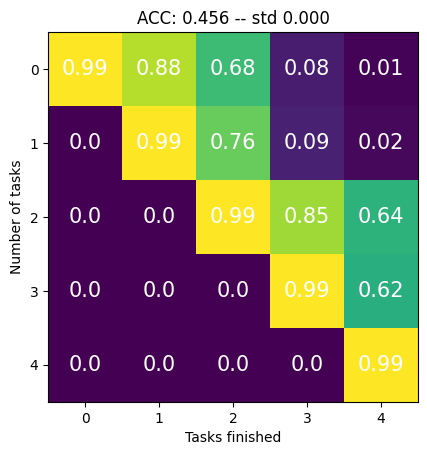

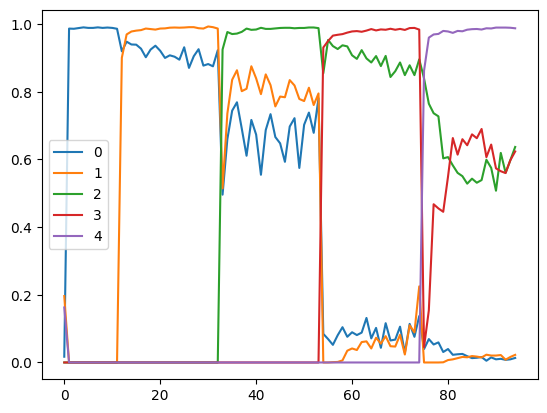

The average accuracy at the end of sequence is: 0.457
BWT: -0.665
FWT: -0.092


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁████
train_accuracy_task_1,▁████
train_accuracy_task_2,▁▇███
train_accuracy_task_3,▁▇███
train_accuracy_task_4,▁▆███
train_loss_task_0,█▁▁▁▁
train_loss_task_1,█▁▁▁▁
train_loss_task_2,█▂▁▁▁


wandb: Agent Starting Run: 43pvdmhj with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 10
wandb: 	lr: 0.001
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/10] | Loss: 299.1817
Epoch [2/10] | Loss: 195.9069
Epoch [3/10] | Loss: 173.5636
Epoch [4/10] | Loss: 164.0177
Epoch [5/10] | Loss: 156.9575
Epoch [6/10] | Loss: 154.3308
Epoch [7/10] | Loss: 151.1243
Epoch [8/10] | Loss: 144.6055
Epoch [9/10] | Loss: 140.5307
Epoch 0: Loss 0.493 Acc: 0.904
Epoch 1: Loss 0.036 Acc: 0.988
Epoch 2: Loss 0.030 Acc: 0.990
Epoch 3: Loss 0.026 Acc: 0.991
Epoch 4: Loss 0.023 Acc: 0.992
Task 1 ---- 
Epoch [1/10] | Loss: 302.3144
Epoch [2/10] | Loss: 242.0583
Epoch [3/10] | Loss: 236.4770
Epoch [4/10] | Loss: 227.5145
Epoch [5/10] | Loss: 231.1612
Epoch [6/10] | Loss: 224.7922
Epoch [7/10] | Loss: 222.9681
Epoch [8/10] | Loss: 222.4532
Epoch [9/10] | Loss: 224.6705
Epoch 0: Loss 0.428 Acc: 0.872
Epoch 1: Loss 0.057 Acc: 0.981
Epoch 2: Loss 0.042 Acc: 0.986
Epoch 3: Loss 0.035 Acc: 0.988
Epoch 4: Loss 0.041 Acc: 0.986
Task 2 ---- 
Epoch [1/10] | Loss: 267.3999
Epoch [2/10] | Loss: 216.4302
Epoch [3/10] | Loss: 201.2599
Epoch [4/10] | Loss: 

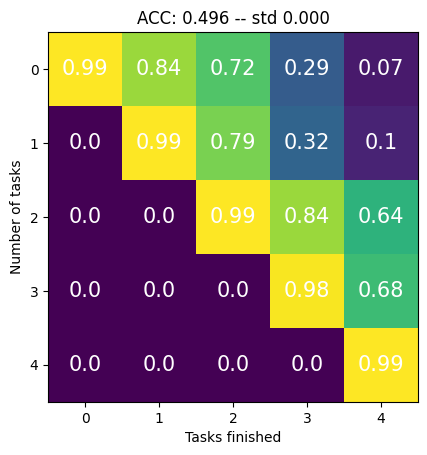

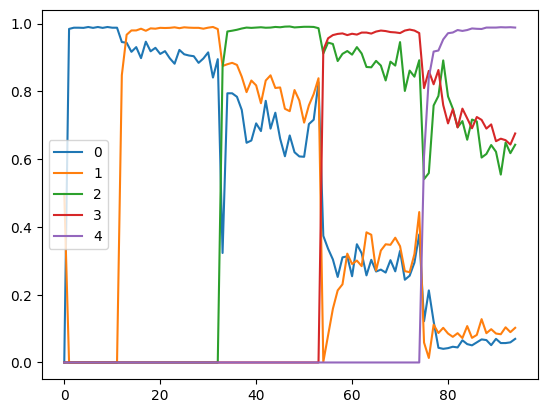

The average accuracy at the end of sequence is: 0.496
BWT: -0.614
FWT: -0.124


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁████
train_accuracy_task_1,▁████
train_accuracy_task_2,▁▇███
train_accuracy_task_3,▁▇███
train_accuracy_task_4,▁▇███
train_loss_task_0,█▁▁▁▁
train_loss_task_1,█▁▁▁▁
train_loss_task_2,█▁▁▁▁


wandb: Agent Starting Run: 5pnp59fu with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 10
wandb: 	lr: 1e-05
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/10] | Loss: 289.6908
Epoch [2/10] | Loss: 190.9466
Epoch [3/10] | Loss: 171.8803
Epoch [4/10] | Loss: 161.6967
Epoch [5/10] | Loss: 151.9548
Epoch [6/10] | Loss: 144.7983
Epoch [7/10] | Loss: 139.9077
Epoch [8/10] | Loss: 136.5298
Epoch [9/10] | Loss: 134.2573
Epoch 0: Loss 2.274 Acc: 0.000
Epoch 1: Loss 2.239 Acc: 0.075
Epoch 2: Loss 2.182 Acc: 0.407
Task 1 ---- 
Epoch [1/10] | Loss: 310.6463
Epoch [2/10] | Loss: 248.1164
Epoch [3/10] | Loss: 237.6066
Epoch [4/10] | Loss: 233.4073
Epoch [5/10] | Loss: 232.3130
Epoch [6/10] | Loss: 228.8765
Epoch [7/10] | Loss: 217.6043
Epoch [8/10] | Loss: 220.8424
Epoch [9/10] | Loss: 211.9421
Epoch 0: Loss 2.213 Acc: 0.390
Epoch 1: Loss 2.043 Acc: 0.385
Epoch 2: Loss 1.885 Acc: 0.385
Task 2 ---- 
Epoch [1/10] | Loss: 270.0222
Epoch [2/10] | Loss: 216.1178
Epoch [3/10] | Loss: 203.8391
Epoch [4/10] | Loss: 198.5352
Epoch [5/10] | Loss: 195.9296
Epoch [6/10] | Loss: 191.7519
Epoch [7/10] | Loss: 196.0106
Epoch [8/10] | Loss: 185.

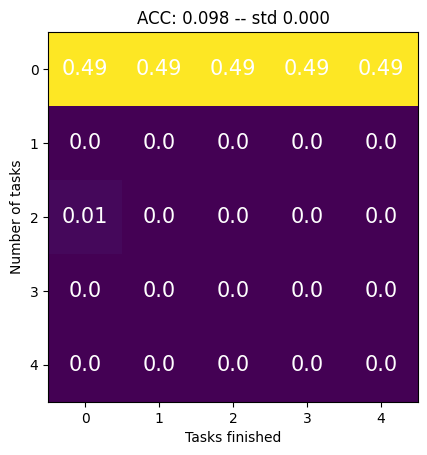

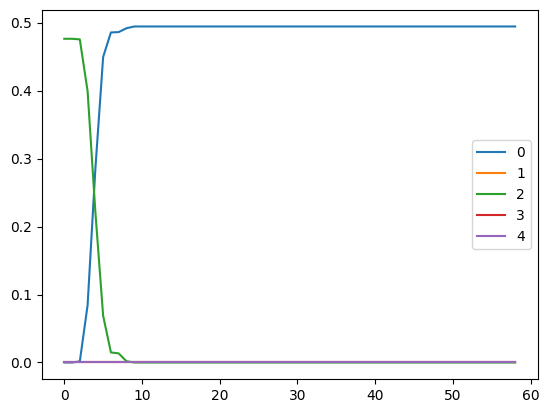

The average accuracy at the end of sequence is: 0.099
BWT: 0.002
FWT: -0.119


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▂█
train_accuracy_task_1,█▁▁
train_accuracy_task_2,▁▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▅▁
train_loss_task_1,█▄▁
train_loss_task_2,█▄▁


wandb: Agent Starting Run: 0lds3iwv with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 10
wandb: 	lr: 1e-05
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/10] | Loss: 292.9623
Epoch [2/10] | Loss: 184.0604
Epoch [3/10] | Loss: 166.4656
Epoch [4/10] | Loss: 155.5229
Epoch [5/10] | Loss: 148.5458
Epoch [6/10] | Loss: 143.6486
Epoch [7/10] | Loss: 140.1390
Epoch [8/10] | Loss: 136.7963
Epoch [9/10] | Loss: 133.6537
Epoch 0: Loss 2.305 Acc: 0.000
Epoch 1: Loss 2.272 Acc: 0.090
Epoch 2: Loss 2.237 Acc: 0.430
Task 1 ---- 
Epoch [1/10] | Loss: 305.3316
Epoch [2/10] | Loss: 244.9730
Epoch [3/10] | Loss: 241.9170
Epoch [4/10] | Loss: 237.9759
Epoch [5/10] | Loss: 223.1651
Epoch [6/10] | Loss: 217.5209
Epoch [7/10] | Loss: 213.0595
Epoch [8/10] | Loss: 223.5163
Epoch [9/10] | Loss: 216.2030
Epoch 0: Loss 2.131 Acc: 0.408
Epoch 1: Loss 1.953 Acc: 0.372
Epoch 2: Loss 1.752 Acc: 0.372
Task 2 ---- 
Epoch [1/10] | Loss: 276.0851
Epoch [2/10] | Loss: 226.3920
Epoch [3/10] | Loss: 210.9670
Epoch [4/10] | Loss: 209.5328
Epoch [5/10] | Loss: 204.3748
Epoch [6/10] | Loss: 200.1922
Epoch [7/10] | Loss: 194.3559
Epoch [8/10] | Loss: 190.

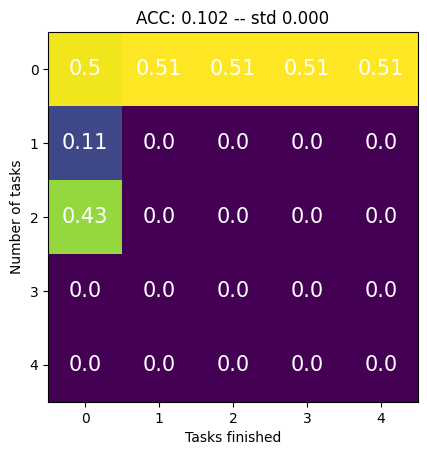

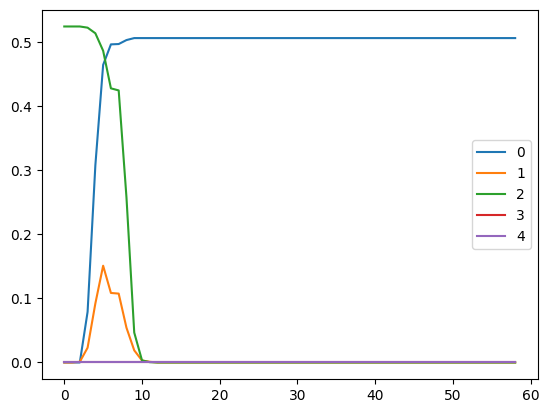

The average accuracy at the end of sequence is: 0.101
BWT: 0.002
FWT: -0.104


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▂█
train_accuracy_task_1,█▁▁
train_accuracy_task_2,▁▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▅▁
train_loss_task_1,█▅▁
train_loss_task_2,█▄▁


wandb: Agent Starting Run: mkdlrfqk with config:
wandb: 	epochs: 3
wandb: 	epochs_VAE: 30
wandb: 	lr: 1e-05
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/30] | Loss: 286.4377
Epoch [2/30] | Loss: 183.1793
Epoch [3/30] | Loss: 162.6213
Epoch [4/30] | Loss: 152.4109
Epoch [5/30] | Loss: 144.9702
Epoch [6/30] | Loss: 139.7355
Epoch [7/30] | Loss: 136.2214
Epoch [8/30] | Loss: 133.1609
Epoch [9/30] | Loss: 130.4587
Epoch [10/30] | Loss: 128.7413
Epoch [11/30] | Loss: 127.2836
Epoch [12/30] | Loss: 125.7855
Epoch [13/30] | Loss: 124.7105
Epoch [14/30] | Loss: 123.7502
Epoch [15/30] | Loss: 122.7038
Epoch [16/30] | Loss: 121.7107
Epoch [17/30] | Loss: 120.8452
Epoch [18/30] | Loss: 120.0812
Epoch [19/30] | Loss: 119.2197
Epoch [20/30] | Loss: 118.4654
Epoch [21/30] | Loss: 117.8329
Epoch [22/30] | Loss: 117.0507
Epoch [23/30] | Loss: 116.3787
Epoch [24/30] | Loss: 115.7934
Epoch [25/30] | Loss: 115.0974
Epoch [26/30] | Loss: 114.5541
Epoch [27/30] | Loss: 114.0756
Epoch [28/30] | Loss: 113.5722
Epoch [29/30] | Loss: 113.0287
Epoch 0: Loss 2.294 Acc: 0.000
Epoch 1: Loss 2.264 Acc: 0.000
Epoch 2: Loss 2.235 Acc: 0.146
Task

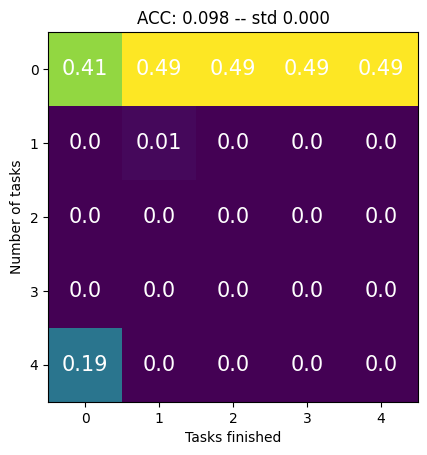

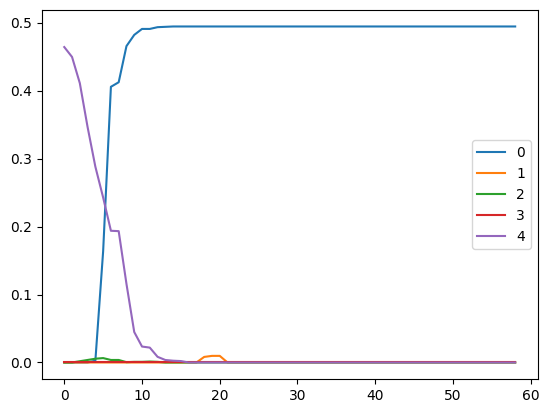

The average accuracy at the end of sequence is: 0.099
BWT: 0.020
FWT: -0.116


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁█
train_accuracy_task_1,█▁▁
train_accuracy_task_2,▁▁▁
train_accuracy_task_3,▁▁▁
train_accuracy_task_4,▁▁▁
train_loss_task_0,█▄▁
train_loss_task_1,█▅▁
train_loss_task_2,█▄▁


wandb: Agent Starting Run: lrevyjrz with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 10
wandb: 	lr: 1e-05
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/10] | Loss: 285.4550
Epoch [2/10] | Loss: 187.1139
Epoch [3/10] | Loss: 168.2063
Epoch [4/10] | Loss: 157.7596
Epoch [5/10] | Loss: 150.5183
Epoch [6/10] | Loss: 143.5961
Epoch [7/10] | Loss: 138.5954
Epoch [8/10] | Loss: 134.1735
Epoch [9/10] | Loss: 130.9559
Epoch 0: Loss 2.181 Acc: 0.477
Epoch 1: Loss 2.130 Acc: 0.532
Epoch 2: Loss 2.076 Acc: 0.687
Epoch 3: Loss 2.010 Acc: 0.916
Epoch 4: Loss 1.921 Acc: 0.932
Task 1 ---- 
Epoch [1/10] | Loss: 302.6524
Epoch [2/10] | Loss: 245.5102
Epoch [3/10] | Loss: 231.2080
Epoch [4/10] | Loss: 226.3602
Epoch [5/10] | Loss: 219.1127
Epoch [6/10] | Loss: 214.1920
Epoch [7/10] | Loss: 212.1071
Epoch [8/10] | Loss: 211.7828
Epoch [9/10] | Loss: 225.1646
Epoch 0: Loss 2.101 Acc: 0.336
Epoch 1: Loss 1.989 Acc: 0.303
Epoch 2: Loss 1.893 Acc: 0.305
Epoch 3: Loss 1.801 Acc: 0.320
Epoch 4: Loss 1.707 Acc: 0.334
Task 2 ---- 
Epoch [1/10] | Loss: 275.9217
Epoch [2/10] | Loss: 228.9285
Epoch [3/10] | Loss: 219.0159
Epoch [4/10] | Loss: 

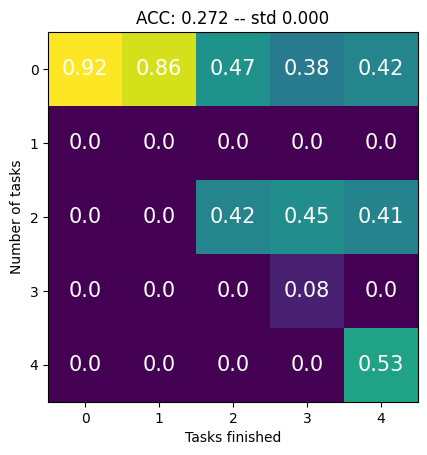

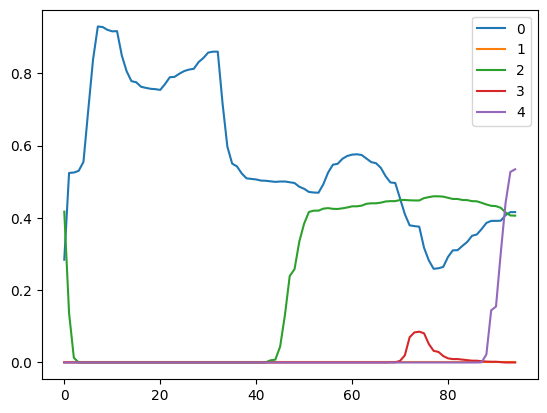

The average accuracy at the end of sequence is: 0.271
BWT: -0.149
FWT: -0.105


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▂▄██
train_accuracy_task_1,█▁▁▄█
train_accuracy_task_2,▂▁▁▃█
train_accuracy_task_3,█▅▃▁▆
train_accuracy_task_4,▂▁▁▂█
train_loss_task_0,█▇▅▃▁
train_loss_task_1,█▆▄▃▁
train_loss_task_2,█▆▄▃▁


wandb: Agent Starting Run: mp12uifj with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 10
wandb: 	lr: 1e-05
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/10] | Loss: 281.6311
Epoch [2/10] | Loss: 181.7336
Epoch [3/10] | Loss: 161.8114
Epoch [4/10] | Loss: 152.2934
Epoch [5/10] | Loss: 146.4451
Epoch [6/10] | Loss: 141.3417
Epoch [7/10] | Loss: 136.8723
Epoch [8/10] | Loss: 133.3466
Epoch [9/10] | Loss: 130.8551
Epoch 0: Loss 2.185 Acc: 0.500
Epoch 1: Loss 2.157 Acc: 0.500
Epoch 2: Loss 2.122 Acc: 0.500
Epoch 3: Loss 2.073 Acc: 0.500
Epoch 4: Loss 1.999 Acc: 0.500
Task 1 ---- 
Epoch [1/10] | Loss: 314.0333
Epoch [2/10] | Loss: 254.3151
Epoch [3/10] | Loss: 244.5887
Epoch [4/10] | Loss: 257.2202
Epoch [5/10] | Loss: 241.0169
Epoch [6/10] | Loss: 243.3994
Epoch [7/10] | Loss: 229.0307
Epoch [8/10] | Loss: 250.8504
Epoch [9/10] | Loss: 232.0374
Epoch 0: Loss 1.893 Acc: 0.485
Epoch 1: Loss 1.638 Acc: 0.485
Epoch 2: Loss 1.470 Acc: 0.485
Epoch 3: Loss 1.343 Acc: 0.485
Epoch 4: Loss 1.230 Acc: 0.485
Task 2 ---- 
Epoch [1/10] | Loss: 263.8472
Epoch [2/10] | Loss: 214.3258
Epoch [3/10] | Loss: 212.6202
Epoch [4/10] | Loss: 

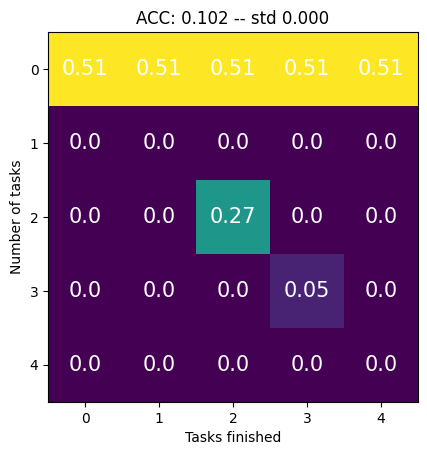

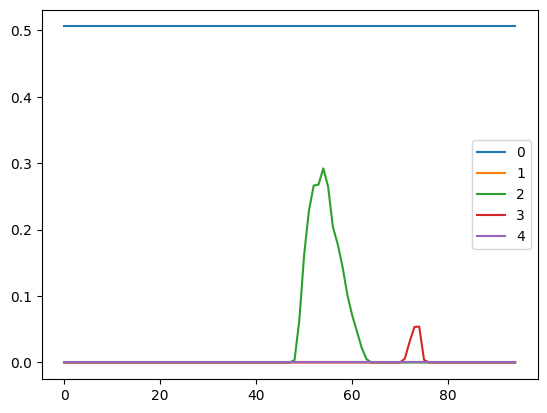

The average accuracy at the end of sequence is: 0.101
BWT: -0.080
FWT: 0.000


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁▁▁▁
train_accuracy_task_1,▁▁▁▁▁
train_accuracy_task_2,▁▁▁▁█
train_accuracy_task_3,█▂▁▁▄
train_accuracy_task_4,▁▁▁▁▁
train_loss_task_0,█▇▆▄▁
train_loss_task_1,█▅▄▂▁
train_loss_task_2,█▆▄▃▁


wandb: Agent Starting Run: wsadwovs with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 30
wandb: 	lr: 0.001
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/30] | Loss: 284.8501
Epoch [2/30] | Loss: 188.2955
Epoch [3/30] | Loss: 167.3092
Epoch [4/30] | Loss: 156.2586
Epoch [5/30] | Loss: 148.3536
Epoch [6/30] | Loss: 142.6072
Epoch [7/30] | Loss: 138.3772
Epoch [8/30] | Loss: 134.4094
Epoch [9/30] | Loss: 132.4474
Epoch [10/30] | Loss: 129.6776
Epoch [11/30] | Loss: 127.5680
Epoch [12/30] | Loss: 126.1166
Epoch [13/30] | Loss: 124.8432
Epoch [14/30] | Loss: 123.7411
Epoch [15/30] | Loss: 122.6392
Epoch [16/30] | Loss: 121.6481
Epoch [17/30] | Loss: 120.8764
Epoch [18/30] | Loss: 119.9780
Epoch [19/30] | Loss: 119.3182
Epoch [20/30] | Loss: 118.5266
Epoch [21/30] | Loss: 117.7934
Epoch [22/30] | Loss: 117.1586
Epoch [23/30] | Loss: 116.6816
Epoch [24/30] | Loss: 116.1134
Epoch [25/30] | Loss: 115.6045
Epoch [26/30] | Loss: 115.0893
Epoch [27/30] | Loss: 114.5765
Epoch [28/30] | Loss: 114.1572
Epoch [29/30] | Loss: 113.7379
Epoch 0: Loss 0.514 Acc: 0.880
Epoch 1: Loss 0.035 Acc: 0.989
Epoch 2: Loss 0.029 Acc: 0.990
Epoc

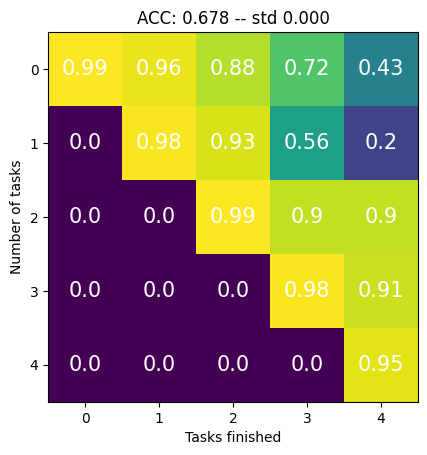

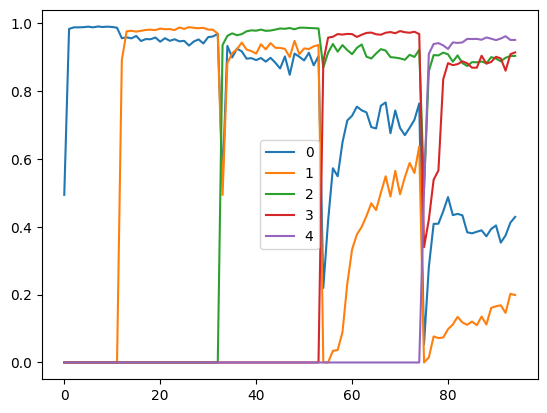

The average accuracy at the end of sequence is: 0.680
BWT: -0.371
FWT: 0.000


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁████
train_accuracy_task_1,▁▇███
train_accuracy_task_2,▁▇███
train_accuracy_task_3,▁▆▇██
train_accuracy_task_4,▁▇▇██
train_loss_task_0,█▁▁▁▁
train_loss_task_1,█▁▁▁▁
train_loss_task_2,█▂▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tdbg6mkj with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 30
wandb: 	lr: 0.001
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/30] | Loss: 285.1307
Epoch [2/30] | Loss: 185.9490
Epoch [3/30] | Loss: 176.7608
Epoch [4/30] | Loss: 164.0523
Epoch [5/30] | Loss: 155.2596
Epoch [6/30] | Loss: 149.4132
Epoch [7/30] | Loss: 144.4870
Epoch [8/30] | Loss: 140.2869
Epoch [9/30] | Loss: 137.8688
Epoch [10/30] | Loss: 134.2425
Epoch [11/30] | Loss: 134.8388
Epoch [12/30] | Loss: 130.4917
Epoch [13/30] | Loss: 128.5152
Epoch [14/30] | Loss: 126.9445
Epoch [15/30] | Loss: 125.7061
Epoch [16/30] | Loss: 124.4454
Epoch [17/30] | Loss: 123.2253
Epoch [18/30] | Loss: 122.1053
Epoch [19/30] | Loss: 121.0572
Epoch [20/30] | Loss: 120.0440
Epoch [21/30] | Loss: 119.1305
Epoch [22/30] | Loss: 118.2325
Epoch [23/30] | Loss: 117.4593
Epoch [24/30] | Loss: 116.7732
Epoch [25/30] | Loss: 116.1290
Epoch [26/30] | Loss: 115.6087
Epoch [27/30] | Loss: 115.0308
Epoch [28/30] | Loss: 114.5012
Epoch [29/30] | Loss: 114.0180
Epoch 0: Loss 0.469 Acc: 0.941
Epoch 1: Loss 0.035 Acc: 0.989
Epoch 2: Loss 0.029 Acc: 0.990
Epoc

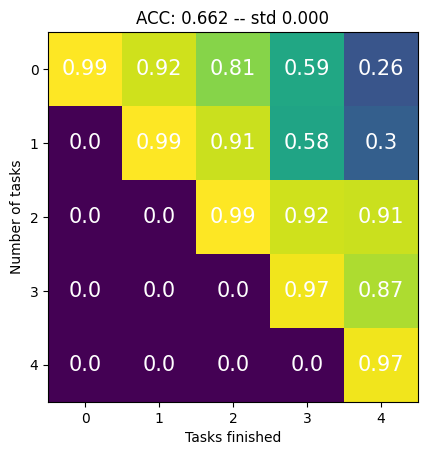

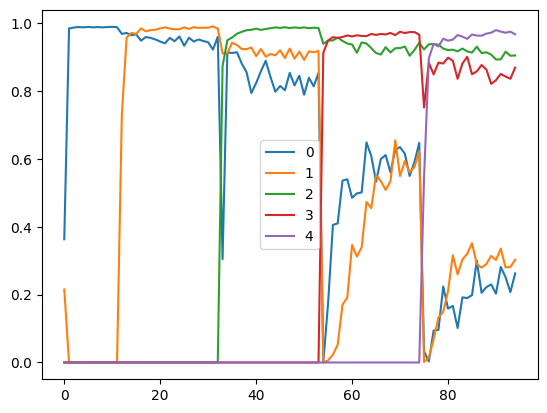

The average accuracy at the end of sequence is: 0.662
BWT: -0.400
FWT: -0.124


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁████
train_accuracy_task_1,▁████
train_accuracy_task_2,▁▇███
train_accuracy_task_3,▁▆▇██
train_accuracy_task_4,▁▇███
train_loss_task_0,█▁▁▁▁
train_loss_task_1,█▂▁▁▁
train_loss_task_2,█▂▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqrlvdg7 with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 30
wandb: 	lr: 1e-05
wandb: 	sample_size: 8000


Task 0 ---- 
Epoch [1/30] | Loss: 284.7172
Epoch [2/30] | Loss: 185.3571
Epoch [3/30] | Loss: 169.0653
Epoch [4/30] | Loss: 156.3773
Epoch [5/30] | Loss: 150.4648
Epoch [6/30] | Loss: 143.1801
Epoch [7/30] | Loss: 141.6880
Epoch [8/30] | Loss: 136.4332
Epoch [9/30] | Loss: 134.7069
Epoch [10/30] | Loss: 130.9728
Epoch [11/30] | Loss: 129.1150
Epoch [12/30] | Loss: 127.1773
Epoch [13/30] | Loss: 125.6767
Epoch [14/30] | Loss: 124.4508
Epoch [15/30] | Loss: 123.3541
Epoch [16/30] | Loss: 122.3844
Epoch [17/30] | Loss: 121.3653
Epoch [18/30] | Loss: 120.5179
Epoch [19/30] | Loss: 119.7224
Epoch [20/30] | Loss: 118.9381
Epoch [21/30] | Loss: 118.2186
Epoch [22/30] | Loss: 117.5185
Epoch [23/30] | Loss: 116.9734
Epoch [24/30] | Loss: 116.3628
Epoch [25/30] | Loss: 115.7899
Epoch [26/30] | Loss: 115.1822
Epoch [27/30] | Loss: 114.7006
Epoch [28/30] | Loss: 114.1637
Epoch [29/30] | Loss: 113.6692
Epoch 0: Loss 2.242 Acc: 0.500
Epoch 1: Loss 2.207 Acc: 0.500
Epoch 2: Loss 2.161 Acc: 0.500
Epoc

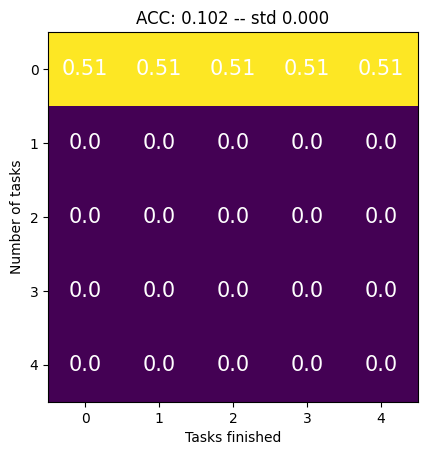

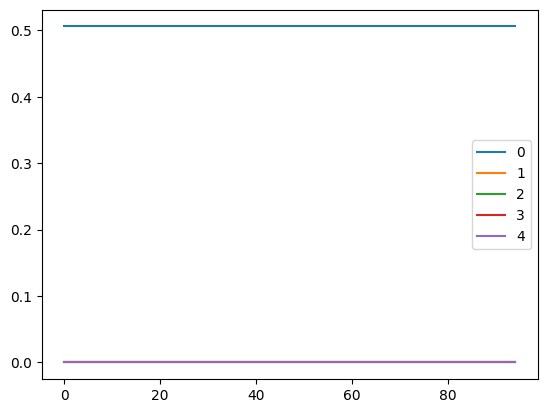

The average accuracy at the end of sequence is: 0.101
BWT: 0.000
FWT: 0.000


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁▁▁▁
train_accuracy_task_1,▁▁▁▁▁
train_accuracy_task_2,▁▁▁▁▁
train_accuracy_task_3,▁▁▁▁▁
train_accuracy_task_4,▁▁▁▁▁
train_loss_task_0,█▇▆▄▁
train_loss_task_1,█▆▄▃▁
train_loss_task_2,█▆▄▃▁


wandb: Agent Starting Run: 3gc7qnlq with config:
wandb: 	epochs: 5
wandb: 	epochs_VAE: 30
wandb: 	lr: 1e-05
wandb: 	sample_size: 11000


Task 0 ---- 
Epoch [1/30] | Loss: 283.5263
Epoch [2/30] | Loss: 183.6941
Epoch [3/30] | Loss: 167.3374
Epoch [4/30] | Loss: 153.3466
Epoch [5/30] | Loss: 145.1519
Epoch [6/30] | Loss: 142.9376
Epoch [7/30] | Loss: 138.0567
Epoch [8/30] | Loss: 141.6215
Epoch [9/30] | Loss: 134.4358
Epoch [10/30] | Loss: 131.1500
Epoch [11/30] | Loss: 128.8558
Epoch [12/30] | Loss: 127.1318
Epoch [13/30] | Loss: 125.7594
Epoch [14/30] | Loss: 124.4952
Epoch [15/30] | Loss: 123.3320
Epoch [16/30] | Loss: 122.3841
Epoch [17/30] | Loss: 121.4764
Epoch [18/30] | Loss: 120.6938
Epoch [19/30] | Loss: 119.8767
Epoch [20/30] | Loss: 119.1068
Epoch [21/30] | Loss: 118.4254
Epoch [22/30] | Loss: 117.7225
Epoch [23/30] | Loss: 117.0754
Epoch [24/30] | Loss: 116.5875
Epoch [25/30] | Loss: 115.9552
Epoch [26/30] | Loss: 115.4379
Epoch [27/30] | Loss: 114.9073
Epoch [28/30] | Loss: 114.4251
Epoch [29/30] | Loss: 113.9657
Epoch 0: Loss 2.211 Acc: 0.500
Epoch 1: Loss 2.177 Acc: 0.500
Epoch 2: Loss 2.123 Acc: 0.500
Epoc

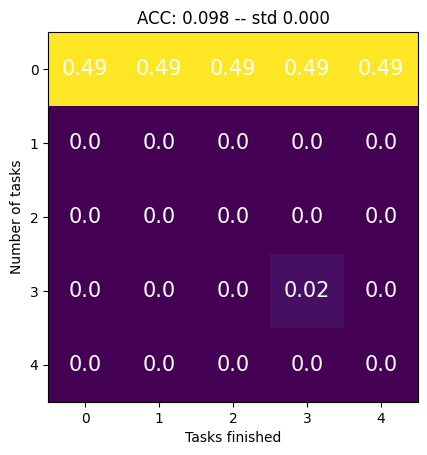

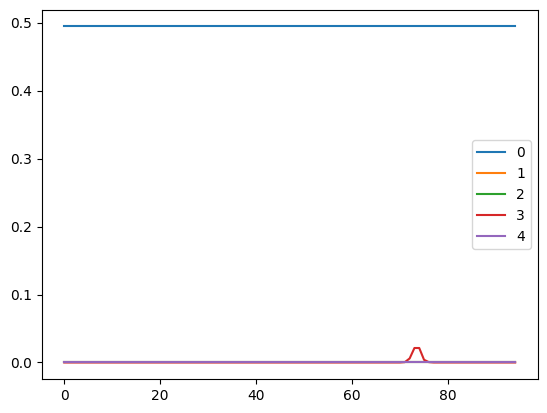

The average accuracy at the end of sequence is: 0.099
BWT: -0.005
FWT: 0.000


average_accuracy,▁
bwt,▁
fwt,▁
train_accuracy_task_0,▁▁▁▁▁
train_accuracy_task_1,▁▁▁▁▁
train_accuracy_task_2,▁▁▁▁▁
train_accuracy_task_3,▁▁▁▁█
train_accuracy_task_4,█▁▁▁▁
train_loss_task_0,█▇▆▄▁
train_loss_task_1,█▆▄▂▁
train_loss_task_2,█▆▄▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:

# wandb.login(key= '15a5e3cf2b8d343a1a7be2785f7583e3565aab2d')

# # Define the sweep configuration
# sweep_config = {
#     'method': 'grid',
#     'metric': {
#         'name': 'average_accuracy',
#         'goal': 'maximize'
#     },
#     # 'parameters': {
#         'lr': {
#             'values': [1e-3, 1e-5]
#         },
#         'epochs_VAE': {
#             'values': [10, 30]
#             },
#         'epochs': {
#             'values': [3, 5]
#         },
#         'sample_size': {
#             'values': [8000, 11000]
#         }
#     }
# }

# # Shuffle classes and create class splits
# base_args = {
#     #'lr': 1e-3,
#     'lr_VAE': 1e-3,
#     #'epochs_VAE': 3,
#     'bs': 128,
#     'num_tasks': 5,
#     'dataset': "MNIST",
#     'num_classes': 10,
#     'in_size': 28,
#     'n_channels': 1,
#     'hidden_size': 50,
#     'device': device,
# }

# classes = list(range(base_args['num_classes']))
# shuffle(classes)
# class_split = {str(i): classes[i*2: (i+1)*2] for i in range(base_args['num_tasks'])}
# print(class_split)

# train, test = get_dataset(dataroot='../data/', dataset=base_args['dataset'])
# train_tasks = split_dataset(train, class_split)
# val_tasks = split_dataset(test, class_split)

# def train_and_evaluate_agent():
#     # Fetch the hyperparameters for the current run
#     run = wandb.init()
#     config = run.config

#     # Merge base args with sweep config
#     args = base_args.copy()
#     args.update(config)
#     args['task_names'] = list(class_split.keys())

#     agent = Agent(args, train_tasks, val_tasks)

#     agent.validate()
#     random_model_acc = [i[0] for i in agent.acc.values()]
#     agent.reset_acc()
#     agent.train()

#     acc_at_end_arr = dict2array(agent.acc_end)
#     plot_accuracy_matrix(acc_at_end_arr)

#     acc_arr = dict2array(agent.acc)
#     plot_acc_over_time(acc_arr)

#     average_accuracy = compute_average_accuracy(acc_at_end_arr)
#     bwt = compute_backward_transfer(acc_at_end_arr)
#     fwt = compute_forward_transfer(acc_at_end_arr, random_model_acc)

#     print(f"The average accuracy at the end of sequence is: {average_accuracy:.3f}")
#     print(f"BWT: {bwt:.3f}")
#     print(f"FWT: {fwt:.3f}")

#     # Log results to wandb
#     wandb.log({
#         'average_accuracy': average_accuracy,
#         'bwt': bwt,
#         'fwt': fwt})
#     # Finish the wandb run
#     wandb.finish()

# # Initialize the sweep
# sweep_id = wandb.sweep(sweep_config, project="CL_assignment_final")

# # Run the sweep
# wandb.agent(sweep_id, function=train_and_evaluate_agent)


{'0': [8, 9], '1': [1, 3], '2': [2, 7], '3': [5, 0], '4': [6, 4]}
Task 0 ---- 
Epoch [1/30] | Loss: 270.6938
Epoch [2/30] | Loss: 179.1900
Epoch [3/30] | Loss: 164.5789
Epoch [4/30] | Loss: 154.2063
Epoch [5/30] | Loss: 148.8439
Epoch [6/30] | Loss: 145.1810
Epoch [7/30] | Loss: 141.9044
Epoch [8/30] | Loss: 141.7943
Epoch [9/30] | Loss: 138.2041
Epoch [10/30] | Loss: 141.1022
Epoch [11/30] | Loss: 135.1579
Epoch [12/30] | Loss: 133.4731
Epoch [13/30] | Loss: 131.7279
Epoch [14/30] | Loss: 130.3227
Epoch [15/30] | Loss: 129.3917
Epoch [16/30] | Loss: 128.0761
Epoch [17/30] | Loss: 127.2521
Epoch [18/30] | Loss: 139.3531
Epoch [19/30] | Loss: 128.8906
Epoch [20/30] | Loss: 126.7693
Epoch [21/30] | Loss: 125.6668
Epoch [22/30] | Loss: 124.7042
Epoch [23/30] | Loss: 124.0259
Epoch [24/30] | Loss: 123.2412
Epoch [25/30] | Loss: 122.5356
Epoch [26/30] | Loss: 121.9195
Epoch [27/30] | Loss: 121.3357
Epoch [28/30] | Loss: 120.7831
Epoch [29/30] | Loss: 120.2819
Epoch 0: Loss 0.577 Acc: 0.792


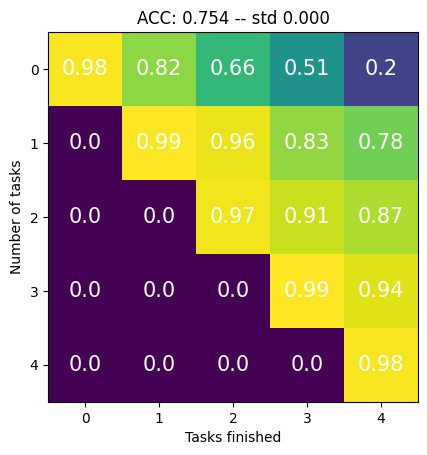

Model Size Efficiency (MS) metric: 1.000


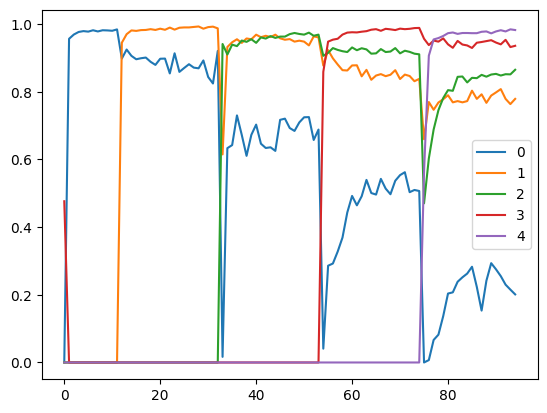

Computational Efficiency (CE) metric: 0.200
The average accuracy at the end of sequence is: 0.753
BWT:'-0.286'
FWT:'-0.119'


In [13]:
torch.autograd.set_detect_anomaly(True)

args = {
    'lr': 1e-3,
    'lr_VAE': 1e-3,
    'epochs_VAE': 30,
    'bs': 128,
    'sample_size':11000,
    'epochs':5,
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50,
    'device': device,
}

classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
print(class_split)
args['task_names'] = list(class_split.keys())

train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)

agent = Agent(args, train_tasks, val_tasks)
agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)


#MS metric
memories = []
for task in agent.train_datasets:
    model_params = count_parameters(agent.model)
    memories.append(model_params)
ms_metric = model_size_efficiency(memories)
print(f"Model Size Efficiency (MS) metric: {ms_metric:.3f}")
acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

#CE metric
ops_list = []
ops_updown_list = []

for task, new_task_data in agent.train_datasets.items():
    loader = DataLoader(new_task_data, batch_size=args['bs'])
    ops = compute_ops_per_epoch(loader, agent.model) * args['epochs']
    ops_updown = count_ops(agent.model, next(iter(loader))[0].shape[1:]) * len(loader)
    ops_list.append(ops)
    ops_updown_list.append(ops_updown)

ce_metric = compute_computational_efficiency(ops_list, ops_updown_list, len(agent.train_datasets))
print(f"Computational Efficiency (CE) metric: {ce_metric:.3f}")
print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")



